In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Import necessary libraries


/var/folders/t8/20x__5p57_771fvzz9p51hhw0000gn/T/ipykernel_61771/3377039693.py:7: DtypeWarning: Columns (29,31,32,34,35,36,37,38,39,40,41,42,46,65,79,85,100,107,112,113,118,136,137,150,156,166,183,186,187,188,191,192,193,197,198,199,200,207,215,216,217,218,220,223,224,225,252,255,256) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_ki = pd.read_csv("main_tx_ki.csv")


               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
KDRI_X     0.718854    2.05208  0.021143        0.677413        0.760294   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                
KDRI_X                1.968779             2.138905     0.0  33.998982   

                       p    -log2(p)  
covariate                             
KDRI_X     2.306293e-253  839.242232  


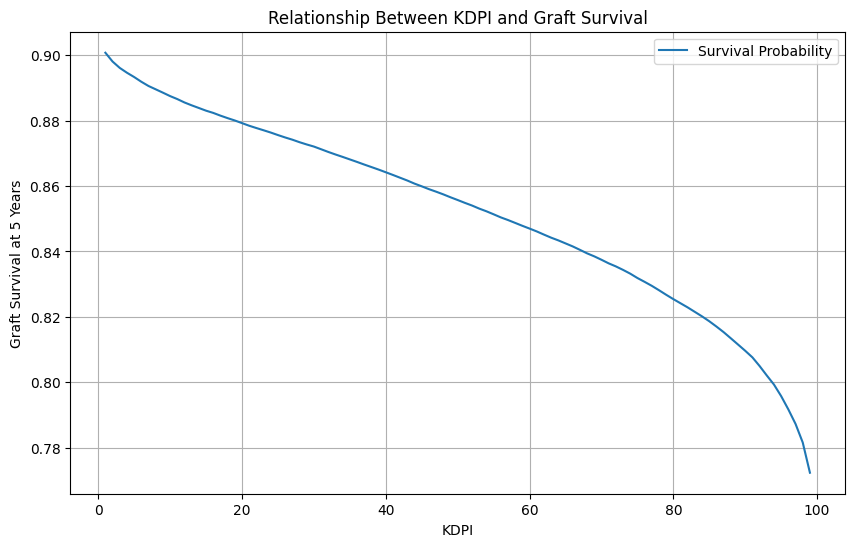

In [ ]:
# Load SRTR file
tx_ki = pd.read_csv("main_tx_ki.csv")

# Define date range and constants
start_date = "2010-01-01"
end_date = "2015-12-31"
scaling_factor = 1.30900852563932
diab_unknown = 0.14911770409153
htn_unknown = 0.38116475987331

# Filter the dataset for the study cohort
study_cohort = tx_ki[
    (tx_ki["REC_TX_DT"] >= start_date) &
    (tx_ki["REC_TX_DT"] <= end_date) &
    (tx_ki["REC_AGE_AT_TX"] >= 18)
].copy()

# Convert date columns to datetime format
date_columns = ["REC_TX_DT", "REC_FAIL_DT", "TFL_DEATH_DT", "TFL_LAFUDATE"]
for col in date_columns:
    study_cohort[col] = pd.to_datetime(study_cohort[col], errors="coerce")

# Convert numerical columns to float
numeric_columns = ["DON_AGE", "DON_HGT_CM", "DON_WGT_KG", "DON_CREAT"]
for col in numeric_columns:
    study_cohort[col] = pd.to_numeric(study_cohort[col], errors="coerce")

# Calculate KDRI components
study_cohort["KDRI_X"] = (
    0.0128 * (study_cohort["DON_AGE"] - 40) +
    np.where(study_cohort["DON_AGE"] < 18, -0.0194 * (study_cohort["DON_AGE"] - 18), 0) +
    np.where(study_cohort["DON_AGE"] > 50, 0.0107 * (study_cohort["DON_AGE"] - 50), 0) +
    -0.0464 * ((study_cohort["DON_HGT_CM"] - 170) / 10) +
    np.where(study_cohort["DON_WGT_KG"] < 80, -0.0199 * ((study_cohort["DON_WGT_KG"] - 80) / 5), 0) +
    np.where(study_cohort["DON_RACE"] == 8, 0.1790, 0) +
    np.where(study_cohort["DON_HTN"] == 1, 0.1260,
             np.where(study_cohort["DON_HTN"].isna(), 0.1260 * htn_unknown, 0)) +
    np.where(study_cohort["DON_HIST_DIAB"].isin([2, 3, 4, 5]), 0.1300,
             np.where(study_cohort["DON_HIST_DIAB"] == 998, 0.1300 * diab_unknown, 0.1300 * diab_unknown)) +
    np.where(study_cohort["DON_CAD_DON_COD"] == 2, 0.0881, 0) +
    0.2200 * (study_cohort["DON_CREAT"] - 1) +
    np.where(study_cohort["DON_CREAT"] > 1.5, -0.2090 * (study_cohort["DON_CREAT"] - 1.5), 0) +
    np.where(study_cohort["DON_ANTI_HCV"] == "P", 0.2400, 0) +
    np.where(study_cohort["DON_NON_HR_BEAT"] == 1, 0.1330, 0)
)

# Calculate KDRI and normalized KDRI
study_cohort["KDRI"] = np.exp(study_cohort["KDRI_X"])
study_cohort["KDRI_normalized"] = study_cohort["KDRI"] / scaling_factor

# Calculate time-to-event and failure status
study_cohort["time"] = np.where(
    study_cohort["REC_FAIL_DT"].notna(),
    (study_cohort["REC_FAIL_DT"] - study_cohort["REC_TX_DT"]).dt.days,
    np.where(
        study_cohort["TFL_DEATH_DT"].notna(),
        (study_cohort["TFL_DEATH_DT"] - study_cohort["REC_TX_DT"]).dt.days,
        (study_cohort["TFL_LAFUDATE"] - study_cohort["REC_TX_DT"]).dt.days
    )
)
study_cohort["failure"] = np.where(
    study_cohort["REC_FAIL_DT"].notna() | (study_cohort["TFL_LASTATUS"] == "D"), 1, 0
)

# Load KDPI mapping table
kdpi_mapping = pd.read_csv("kdpi_mapping_table.csv")

# Ensure KDPI column in kdpi_mapping is of string type before stripping "%"
if kdpi_mapping["KDPI"].dtype != "object":
    kdpi_mapping["KDPI"] = kdpi_mapping["KDPI"].astype(str)

# Strip "%" and convert KDPI to float
kdpi_mapping["KDPI"] = kdpi_mapping["KDPI"].str.rstrip("%").astype(float)

# Define the function to map KDPI based on KDRI value
def find_kdpi(kdri_value):
    row = kdpi_mapping[
        (kdpi_mapping["KDRI_min"] <= kdri_value) &
        (kdpi_mapping["KDRI_max"] >= kdri_value)
    ]
    return row["KDPI"].values[0] if not row.empty else None

# Apply the mapping function
study_cohort["KDPI"] = study_cohort["KDRI_normalized"].apply(find_kdpi)

# Ensure KDPI column is numeric and drop rows with missing values
study_cohort["KDPI"] = pd.to_numeric(study_cohort["KDPI"], errors="coerce")
study_cohort = study_cohort.dropna(subset=["KDPI"])

# Fit Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(study_cohort[["time", "failure", "KDRI_X"]], duration_col="time", event_col="failure")

# Summary of the model
print(cph.summary)

# Generate predicted survival at 5 years
kdri_to_plot = kdpi_mapping.copy()
kdri_to_plot = kdri_to_plot[(kdri_to_plot["KDPI"] > 0) & (kdri_to_plot["KDPI"] < 100)]
kdri_to_plot["KDRI"] = kdri_to_plot["KDRI_max"] * scaling_factor
kdri_to_plot["KDRI_X"] = np.log(kdri_to_plot["KDRI"])

xbetas = cph.predict_partial_hazard(kdri_to_plot)

# Use the cumulative baseline hazard at 5 years
baseline_cumulative_hazard_at_5_years = cph.baseline_cumulative_hazard_.loc[5 * 365].values[0]
kdri_to_plot["surv_prob_5yr"] = np.exp(-baseline_cumulative_hazard_at_5_years * xbetas)

# Plot survival probability
plt.figure(figsize=(10, 6))
plt.plot(kdri_to_plot["KDPI"], kdri_to_plot["surv_prob_5yr"], label="Survival Probability")
plt.xlabel("KDPI")
plt.ylabel("Graft Survival at 5 Years")
plt.title("Relationship Between KDPI and Graft Survival")
plt.legend()
plt.grid()
plt.show()

In [2]:
# Define for_dca from study_cohort
for_dca = study_cohort.copy()
for_dca["five_year_survival"] = (for_dca["time"] > 5 * 365).astype(int)
for_dca = for_dca[["PX_ID", "KDPI", "KDRI_normalized", "time", "failure", "five_year_survival"]]
for_dca = for_dca.dropna(subset=["KDPI"])  # Filter rows with valid KDPI

# Define the function to calculate the confusion matrix for a given KDPI threshold
def confusion_matrix(KDPI_threshold, for_dca, time=365 * 5):
    # Subset of kidneys with KDPI <= threshold (accepted kidneys)
    accepted_kidneys = for_dca[for_dca["KDPI"] <= KDPI_threshold]
    if len(accepted_kidneys) == 0:
        return None  # Skip if no accepted kidneys
    
    # Probability of accepting a kidney (P(x = 1))
    p_accept = len(accepted_kidneys) / len(for_dca)
    
    # Kaplan-Meier survival curve for accepted kidneys
    kmf_accepted = KaplanMeierFitter()
    if len(accepted_kidneys) > 0:
        kmf_accepted.fit(durations=accepted_kidneys["time"], event_observed=accepted_kidneys["failure"])
        survival_at_time = kmf_accepted.survival_function_at_times(time).values[0]
    else:
        survival_at_time = 0  # No survival data if no accepted kidneys

    # Calculate accepted kidneys that survive and fail
    accept_survive = survival_at_time * p_accept * len(for_dca)
    accept_fail = (1 - survival_at_time) * p_accept * len(for_dca)
    
    # Subset of kidneys with KDPI > threshold (rejected kidneys)
    rejected_kidneys = for_dca[for_dca["KDPI"] > KDPI_threshold]
    if len(rejected_kidneys) == 0:
        return None  # Skip if no rejected kidneys
    
    # Probability of rejecting a kidney (P(x = 0))
    p_reject = len(rejected_kidneys) / len(for_dca)
    
    # Kaplan-Meier survival curve for rejected kidneys
    kmf_rejected = KaplanMeierFitter()
    if len(rejected_kidneys) > 0:
        kmf_rejected.fit(durations=rejected_kidneys["time"], event_observed=rejected_kidneys["failure"])
        survival_at_time_rejected = kmf_rejected.survival_function_at_times(time).values[0]
    else:
        survival_at_time_rejected = 0  # No survival data if no rejected kidneys

    # Calculate rejected kidneys that would survive and fail
    reject_survive = survival_at_time_rejected * p_reject * len(for_dca)
    reject_fail = (1 - survival_at_time_rejected) * p_reject * len(for_dca)
    
    # Create a DataFrame to return the confusion matrix
    cm_df = pd.DataFrame({
        "KDPI": [KDPI_threshold],
        "proportion_accepted": [p_accept],
        "total_kidneys": [len(for_dca)],
        "accept_survive": [accept_survive],
        "accept_fail": [accept_fail],
        "reject_survive": [reject_survive],
        "reject_fail": [reject_fail],
        "check_sum": [accept_survive + accept_fail + reject_survive + reject_fail]
    })
    
    return cm_df

# Apply the confusion_matrix function to each row of kdri_to_plot["KDPI"]
confusion_matrices = pd.concat(
    [confusion_matrix(kdpi, for_dca) for kdpi in kdri_to_plot["KDPI"] if confusion_matrix(kdpi, for_dca) is not None],
    ignore_index=True
)

# Display results
print(confusion_matrices.head())


   KDPI  proportion_accepted  total_kidneys  accept_survive  accept_fail  \
0   1.0             0.010313          64674      604.133055    62.866945   
1   2.0             0.019034          64674     1108.037462   122.962538   
2   3.0             0.027739          64674     1609.925926   184.074074   
3   4.0             0.036135          64674     2099.731921   237.268079   
4   5.0             0.044361          64674     2584.015386   284.984614   

   reject_survive  reject_fail  check_sum  
0    54578.776837  9428.223163    64674.0  
1    54074.837960  9368.162040    64674.0  
2    53572.741067  9307.258933    64674.0  
3    53082.760186  9254.239814    64674.0  
4    52598.194611  9206.805389    64674.0  


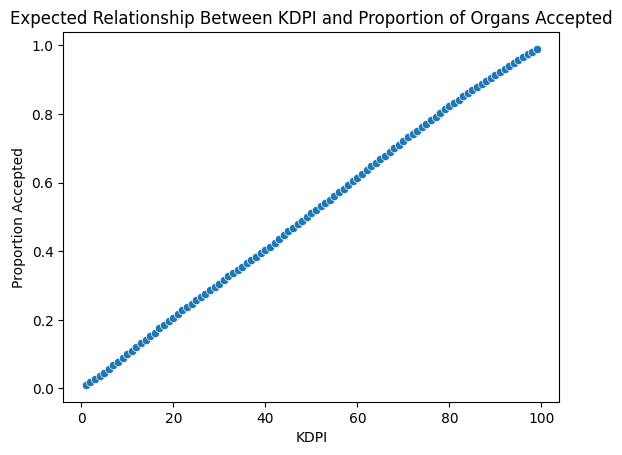

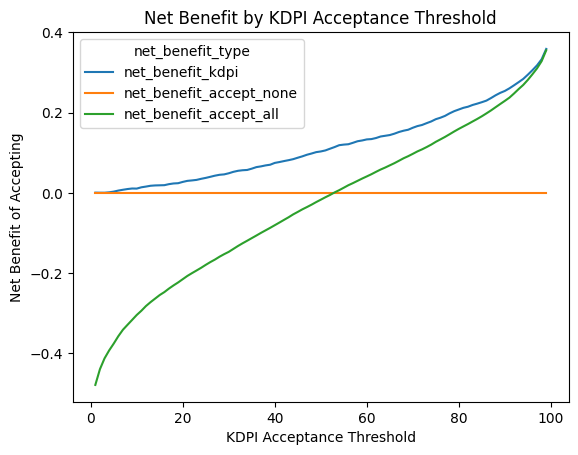

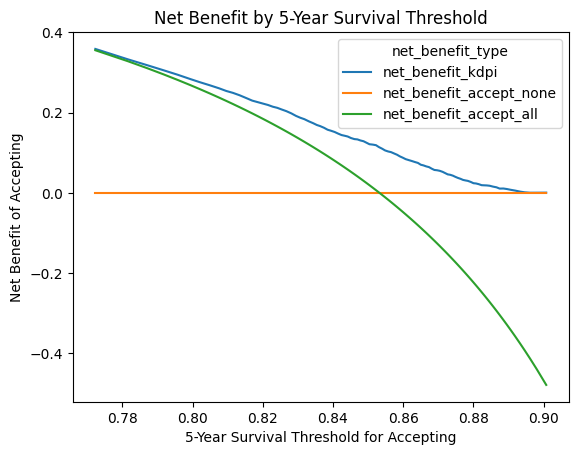

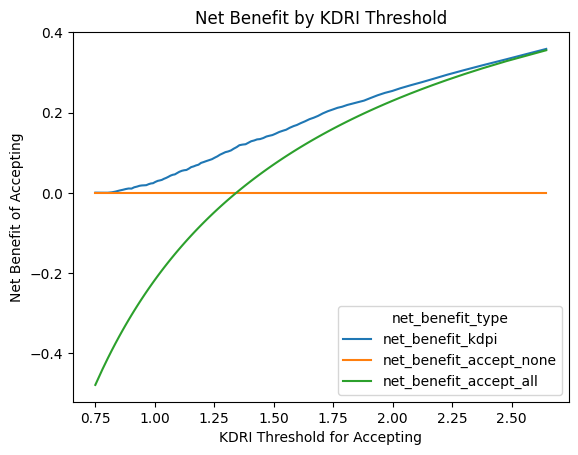

In [ ]:
# Assuming `confusion_matrices` and `kdri_to_plot` are pandas DataFrames
# Assuming `time`, `failure`, and `for_dca` are columns in your dataset

# --- Expected relationship between KDPI and proportion of organs accepted ---
sns.scatterplot(data=confusion_matrices, x='KDPI', y='proportion_accepted')
plt.xlabel('KDPI')
plt.ylabel('Proportion Accepted')
plt.title('Expected Relationship Between KDPI and Proportion of Organs Accepted')
plt.show()

# --- Net benefit for patients who accept the kidney ---
kmf = KaplanMeierFitter()
kmf.fit(for_dca['time'], event_observed=for_dca['failure'])

# Extracting the 5-year survival probability
time_point = 5 * 365  # Assuming time is in days
overall_five_year_survival = kmf.survival_function_at_times(time_point).values[0]

# Calculating net benefits
for_dca_plot = confusion_matrices.merge(kdri_to_plot, on='KDPI', how='left')
for_dca_plot['net_benefit_kdpi'] = (1 / for_dca_plot['total_kidneys']) * (
    for_dca_plot['accept_survive'] - for_dca_plot['accept_fail'] *
    (for_dca_plot['surv_prob_5yr'] / (1 - for_dca_plot['surv_prob_5yr']))
)
for_dca_plot['net_benefit_accept_none'] = 0
for_dca_plot['net_benefit_accept_all'] = (
    overall_five_year_survival -
    (1 - overall_five_year_survival) *
    (for_dca_plot['surv_prob_5yr'] / (1 - for_dca_plot['surv_prob_5yr']))
)

# Pivot for plotting
for_dca_long = for_dca_plot.melt(
    id_vars=['KDPI'],
    value_vars=['net_benefit_kdpi', 'net_benefit_accept_none', 'net_benefit_accept_all'],
    var_name='net_benefit_type',
    value_name='value'
)

# Plot net benefits by KDPI
sns.lineplot(data=for_dca_long, x='KDPI', y='value', hue='net_benefit_type')
plt.xlabel('KDPI Acceptance Threshold')
plt.ylabel('Net Benefit of Accepting')
plt.title('Net Benefit by KDPI Acceptance Threshold')
plt.show()

# --- Plotting net benefit vs 5-year survival probability ---
survival_long = for_dca_plot.melt(
    id_vars=['surv_prob_5yr'],
    value_vars=['net_benefit_kdpi', 'net_benefit_accept_none', 'net_benefit_accept_all'],
    var_name='net_benefit_type',
    value_name='value'
)

sns.lineplot(data=survival_long, x='surv_prob_5yr', y='value', hue='net_benefit_type')
plt.xlabel('5-Year Survival Threshold for Accepting')
plt.ylabel('Net Benefit of Accepting')
plt.title('Net Benefit by 5-Year Survival Threshold')
plt.show()

# --- Plotting net benefit vs KDRI ---
kdri_long = for_dca_plot.melt(
    id_vars=['KDRI'],
    value_vars=['net_benefit_kdpi', 'net_benefit_accept_none', 'net_benefit_accept_all'],
    var_name='net_benefit_type',
    value_name='value'
)

sns.lineplot(data=kdri_long, x='KDRI', y='value', hue='net_benefit_type')
plt.xlabel('KDRI Threshold for Accepting')
plt.ylabel('Net Benefit of Accepting')
plt.title('Net Benefit by KDRI Threshold')
plt.show()


## KDRI full

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Import necessary libraries

In [ ]:
 # Load SRTR files
tx_ki = pd.read_csv("main_tx_ki.csv")
dd_ki = pd.read_csv("donor_deceased.csv")

#Join tx_ki w/ N_COLD_ISCH_TM_ARRIV_KI and DONN_USE_DOUBLE_KI from dd_ki
study_cohort = pd.merge(tx_ki, dd_ki[["DONOR_ID","DON_USE_DOUBLE_KI"]], how='left', on='DONOR_ID')

/var/folders/t8/20x__5p57_771fvzz9p51hhw0000gn/T/ipykernel_48467/23171152.py:2: DtypeWarning: Columns (29,31,32,34,35,36,37,38,39,40,41,42,46,65,79,85,100,107,112,113,118,136,137,150,156,166,183,186,187,188,191,192,193,197,198,199,200,207,215,216,217,218,220,223,224,225,252,255,256) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_ki = pd.read_csv("main_tx_ki.csv")
/var/folders/t8/20x__5p57_771fvzz9p51hhw0000gn/T/ipykernel_48467/23171152.py:3: DtypeWarning: Columns (17,58,70,73,75,77,79,138,181,194,249,250,251,252,253,254) have mixed types. Specify dtype option on import or set low_memory=False.
  dd_ki = pd.read_csv("donor_deceased.csv")


In [12]:
# Define date range and constants
start_date = "2010-01-01"
end_date = "2015-12-31"
scaling_factor = 1.30900852563932
diab_unknown = 0.14911770409153
htn_unknown = 0.38116475987331

# Filter the dataset for the study cohort
study_cohort = tx_ki[
    (tx_ki["REC_TX_DT"] >= start_date) &
    (tx_ki["REC_TX_DT"] <= end_date) &
    (tx_ki["REC_AGE_AT_TX"] >= 18)
].copy()

# Convert date columns to datetime format
date_columns = ["REC_TX_DT", "REC_FAIL_DT", "TFL_DEATH_DT", "TFL_LAFUDATE"]
for col in date_columns:
    study_cohort[col] = pd.to_datetime(study_cohort[col], errors="coerce")

# Convert numerical columns to float
numeric_columns = ["DON_AGE", "DON_HGT_CM", "DON_WGT_KG", "DON_CREAT"]
for col in numeric_columns:
    study_cohort[col] = pd.to_numeric(study_cohort[col], errors="coerce")

In [14]:
# Calculate KDRI components
study_cohort["KDRI_X"] = (
    0.0128 * (study_cohort["DON_AGE"] - 40) +
    np.where(study_cohort["DON_AGE"] < 18, -0.0194 * (study_cohort["DON_AGE"] - 18), 0) +
    np.where(study_cohort["DON_AGE"] > 50, 0.0107 * (study_cohort["DON_AGE"] - 50), 0) +
    -0.0464 * ((study_cohort["DON_HGT_CM"] - 170) / 10) +
    np.where(study_cohort["DON_WGT_KG"] < 80, -0.0199 * ((study_cohort["DON_WGT_KG"] - 80) / 5), 0) +
    np.where(study_cohort["DON_RACE"] == 8, 0.1790, 0) +
    np.where(study_cohort["DON_HTN"] == 1, 0.1260,
             np.where(study_cohort["DON_HTN"].isna(), 0.1260 * htn_unknown, 0)) +
    np.where(study_cohort["DON_HIST_DIAB"].isin([2, 3, 4, 5]), 0.1300,
             np.where(study_cohort["DON_HIST_DIAB"] == 998, 0.1300 * diab_unknown, 0.1300 * diab_unknown)) +
    np.where(study_cohort["DON_CAD_DON_COD"] == 2, 0.0881, 0) +
    0.2200 * (study_cohort["DON_CREAT"] - 1) +
    np.where(study_cohort["DON_CREAT"] > 1.5, -0.2090 * (study_cohort["DON_CREAT"] - 1.5), 0) +
    np.where(study_cohort["DON_ANTI_HCV"] == "P", 0.2400, 0) +
    np.where(study_cohort["DON_NON_HR_BEAT"] == 1, 0.1330, 0) +
    
    # HLA-B mismatch component -- from tx_ki
    np.where(study_cohort["REC_B_MM_EQUIV_TX"] == 0, -0.0766, 0) +
    np.where(study_cohort["REC_B_MM_EQUIV_TX"] == 1, -0.0610, 0) +
    
    # HLA-DR mismatch component -- from tx_ki
    np.where(study_cohort["REC_DR_MM_EQUIV_TX"] == 0, -0.1300, 0) +
    np.where(study_cohort["REC_DR_MM_EQUIV_TX"] == 2, 0.0765, 0) +
    
    # Cold ischemia time component -- from deceased_donor
    0.00548 * (study_cohort["REC_COLD_ISCH_TM"] - 20) +
    
    # En bloc transplant component -- from tx_ki
    np.where(study_cohort["REC_TX_PROCEDURE_TY"] == 103, -0.364, 0) +
    
    # Double kidney transplant component -- from deceased donor
    np.where(study_cohort["REC_TX_PROCEDURE_TY"] == 104, -0.148, 0)
)

# Exponentiate to calculate final KDRI
study_cohort["KDRI"] = np.exp(study_cohort["KDRI_X"])


               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
KDRI_X     0.695062   2.003834  0.019624        0.656601        0.733524   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
KDRI_X                1.928226             2.082407     0.0  35.41941   

                       p    -log2(p)  
covariate                             
KDRI_X     8.582602e-275  910.428811  


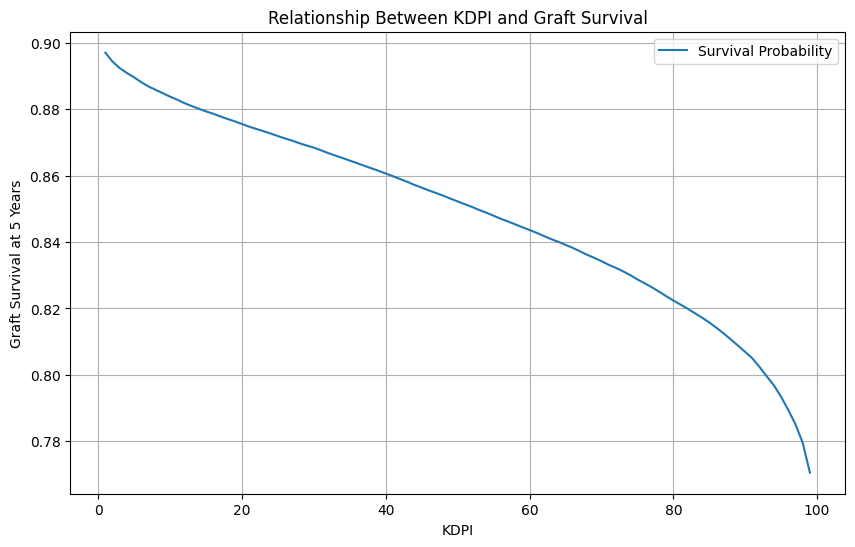

In [15]:
# Calculate KDRI and normalized KDRI
study_cohort["KDRI"] = np.exp(study_cohort["KDRI_X"])
study_cohort["KDRI_normalized"] = study_cohort["KDRI"] / scaling_factor

# Calculate time-to-event and failure status
study_cohort["time"] = np.where(
    study_cohort["REC_FAIL_DT"].notna(),
    (study_cohort["REC_FAIL_DT"] - study_cohort["REC_TX_DT"]).dt.days,
    np.where(
        study_cohort["TFL_DEATH_DT"].notna(),
        (study_cohort["TFL_DEATH_DT"] - study_cohort["REC_TX_DT"]).dt.days,
        (study_cohort["TFL_LAFUDATE"] - study_cohort["REC_TX_DT"]).dt.days
    )
)
study_cohort["failure"] = np.where(
    study_cohort["REC_FAIL_DT"].notna() | (study_cohort["TFL_LASTATUS"] == "D"), 1, 0
)

# Load KDPI mapping table
kdpi_mapping = pd.read_csv("kdpi_mapping_table.csv")

# Ensure KDPI column in kdpi_mapping is of string type before stripping "%"
if kdpi_mapping["KDPI"].dtype != "object":
    kdpi_mapping["KDPI"] = kdpi_mapping["KDPI"].astype(str)

# Strip "%" and convert KDPI to float
kdpi_mapping["KDPI"] = kdpi_mapping["KDPI"].str.rstrip("%").astype(float)

# Define the function to map KDPI based on KDRI value
def find_kdpi(kdri_value):
    row = kdpi_mapping[
        (kdpi_mapping["KDRI_min"] <= kdri_value) &
        (kdpi_mapping["KDRI_max"] >= kdri_value)
    ]
    return row["KDPI"].values[0] if not row.empty else None

# Apply the mapping function
study_cohort["KDPI"] = study_cohort["KDRI_normalized"].apply(find_kdpi)

# Ensure KDPI column is numeric and drop rows with missing values
study_cohort["KDPI"] = pd.to_numeric(study_cohort["KDPI"], errors="coerce")
study_cohort = study_cohort.dropna(subset=["KDPI"])

# Fit Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(study_cohort[["time", "failure", "KDRI_X"]], duration_col="time", event_col="failure")

# Summary of the model
print(cph.summary)

# Generate predicted survival at 5 years
kdri_to_plot = kdpi_mapping.copy()
kdri_to_plot = kdri_to_plot[(kdri_to_plot["KDPI"] > 0) & (kdri_to_plot["KDPI"] < 100)]
kdri_to_plot["KDRI"] = kdri_to_plot["KDRI_max"] * scaling_factor
kdri_to_plot["KDRI_X"] = np.log(kdri_to_plot["KDRI"])

xbetas = cph.predict_partial_hazard(kdri_to_plot)

# Use the cumulative baseline hazard at 5 years
baseline_cumulative_hazard_at_5_years = cph.baseline_cumulative_hazard_.loc[5 * 365].values[0]
kdri_to_plot["surv_prob_5yr"] = np.exp(-baseline_cumulative_hazard_at_5_years * xbetas)

# Plot survival probability
plt.figure(figsize=(10, 6))
plt.plot(kdri_to_plot["KDPI"], kdri_to_plot["surv_prob_5yr"], label="Survival Probability")
plt.xlabel("KDPI")
plt.ylabel("Graft Survival at 5 Years")
plt.title("Relationship Between KDPI and Graft Survival")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Define for_dca from study_cohort
for_dca = study_cohort.copy()
for_dca["five_year_survival"] = (for_dca["time"] > 5 * 365).astype(int)
for_dca = for_dca[["PX_ID", "KDPI", "KDRI_normalized", "time", "failure", "five_year_survival"]]
for_dca = for_dca.dropna(subset=["KDPI"])  # Filter rows with valid KDPI

# Define the function to calculate the confusion matrix for a given KDPI threshold
def confusion_matrix(KDPI_threshold, for_dca, time=365 * 5):
    # Subset of kidneys with KDPI <= threshold (accepted kidneys)
    accepted_kidneys = for_dca[for_dca["KDPI"] <= KDPI_threshold]
    if len(accepted_kidneys) == 0:
        return None  # Skip if no accepted kidneys
    
    # Probability of accepting a kidney (P(x = 1))
    p_accept = len(accepted_kidneys) / len(for_dca)
    
    # Kaplan-Meier survival curve for accepted kidneys
    kmf_accepted = KaplanMeierFitter()
    if len(accepted_kidneys) > 0:
        kmf_accepted.fit(durations=accepted_kidneys["time"], event_observed=accepted_kidneys["failure"])
        survival_at_time = kmf_accepted.survival_function_at_times(time).values[0]
    else:
        survival_at_time = 0  # No survival data if no accepted kidneys

    # Calculate accepted kidneys that survive and fail
    accept_survive = survival_at_time * p_accept * len(for_dca)
    accept_fail = (1 - survival_at_time) * p_accept * len(for_dca)
    
    # Subset of kidneys with KDPI > threshold (rejected kidneys)
    rejected_kidneys = for_dca[for_dca["KDPI"] > KDPI_threshold]
    if len(rejected_kidneys) == 0:
        return None  # Skip if no rejected kidneys
    
    # Probability of rejecting a kidney (P(x = 0))
    p_reject = len(rejected_kidneys) / len(for_dca)
    
    # Kaplan-Meier survival curve for rejected kidneys
    kmf_rejected = KaplanMeierFitter()
    if len(rejected_kidneys) > 0:
        kmf_rejected.fit(durations=rejected_kidneys["time"], event_observed=rejected_kidneys["failure"])
        survival_at_time_rejected = kmf_rejected.survival_function_at_times(time).values[0]
    else:
        survival_at_time_rejected = 0  # No survival data if no rejected kidneys

    # Calculate rejected kidneys that would survive and fail
    reject_survive = survival_at_time_rejected * p_reject * len(for_dca)
    reject_fail = (1 - survival_at_time_rejected) * p_reject * len(for_dca)
    
    # Create a DataFrame to return the confusion matrix
    cm_df = pd.DataFrame({
        "KDPI": [KDPI_threshold],
        "proportion_accepted": [p_accept],
        "total_kidneys": [len(for_dca)],
        "accept_survive": [accept_survive],
        "accept_fail": [accept_fail],
        "reject_survive": [reject_survive],
        "reject_fail": [reject_fail],
        "check_sum": [accept_survive + accept_fail + reject_survive + reject_fail]
    })
    
    return cm_df

# Apply the confusion_matrix function to each row of kdri_to_plot["KDPI"]
confusion_matrices = pd.concat(
    [confusion_matrix(kdpi, for_dca) for kdpi in kdri_to_plot["KDPI"] if confusion_matrix(kdpi, for_dca) is not None],
    ignore_index=True
)

# Display results
print(confusion_matrices.head())


   KDPI  proportion_accepted  total_kidneys  accept_survive  accept_fail  \
0   1.0             0.035127          64082     2052.691412   198.308588   
1   2.0             0.051949          64082     3020.348930   308.651070   
2   3.0             0.066415          64082     3864.436596   391.563404   
3   4.0             0.079289          64082     4621.122919   459.877081   
4   5.0             0.091492          64082     5318.231496   544.768504   

   reject_survive  reject_fail  check_sum  
0    52647.518440  9183.481560    64082.0  
1    51679.404087  9073.595913    64082.0  
2    50834.483243  8991.516757    64082.0  
3    50077.423428  8923.576572    64082.0  
4    49380.400648  8838.599352    64082.0  


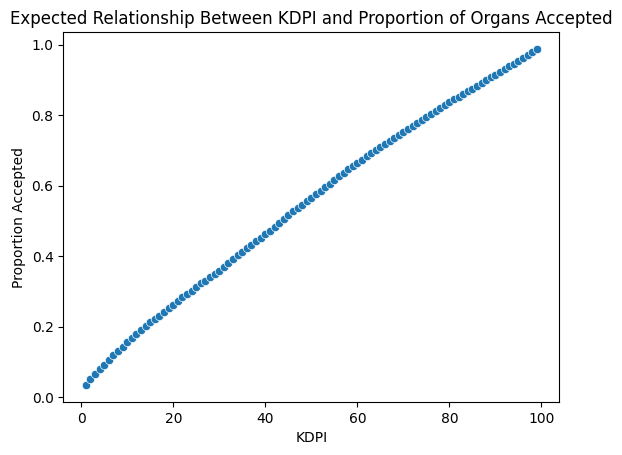

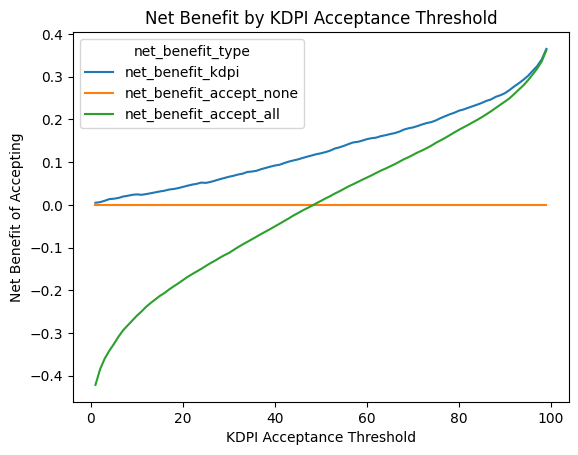

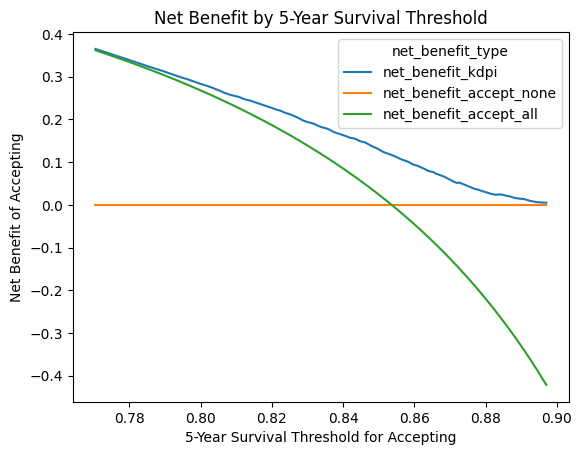

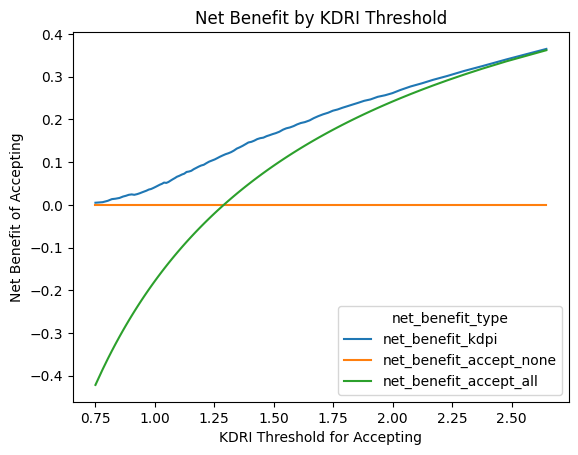

In [17]:
# Assuming `confusion_matrices` and `kdri_to_plot` are pandas DataFrames
# Assuming `time`, `failure`, and `for_dca` are columns in your dataset

# --- Expected relationship between KDPI and proportion of organs accepted ---
sns.scatterplot(data=confusion_matrices, x='KDPI', y='proportion_accepted')
plt.xlabel('KDPI')
plt.ylabel('Proportion Accepted')
plt.title('Expected Relationship Between KDPI and Proportion of Organs Accepted')
plt.show()

# --- Net benefit for patients who accept the kidney ---
kmf = KaplanMeierFitter()
kmf.fit(for_dca['time'], event_observed=for_dca['failure'])

# Extracting the 5-year survival probability
time_point = 5 * 365  # Assuming time is in days
overall_five_year_survival = kmf.survival_function_at_times(time_point).values[0]

# Calculating net benefits
for_dca_plot = confusion_matrices.merge(kdri_to_plot, on='KDPI', how='left')
for_dca_plot['net_benefit_kdpi'] = (1 / for_dca_plot['total_kidneys']) * (
    for_dca_plot['accept_survive'] - for_dca_plot['accept_fail'] *
    (for_dca_plot['surv_prob_5yr'] / (1 - for_dca_plot['surv_prob_5yr']))
)
for_dca_plot['net_benefit_accept_none'] = 0
for_dca_plot['net_benefit_accept_all'] = (
    overall_five_year_survival -
    (1 - overall_five_year_survival) *
    (for_dca_plot['surv_prob_5yr'] / (1 - for_dca_plot['surv_prob_5yr']))
)

# Pivot for plotting
for_dca_long = for_dca_plot.melt(
    id_vars=['KDPI'],
    value_vars=['net_benefit_kdpi', 'net_benefit_accept_none', 'net_benefit_accept_all'],
    var_name='net_benefit_type',
    value_name='value'
)

# Plot net benefits by KDPI
sns.lineplot(data=for_dca_long, x='KDPI', y='value', hue='net_benefit_type')
plt.xlabel('KDPI Acceptance Threshold')
plt.ylabel('Net Benefit of Accepting')
plt.title('Net Benefit by KDPI Acceptance Threshold')
plt.show()

# --- Plotting net benefit vs 5-year survival probability ---
survival_long = for_dca_plot.melt(
    id_vars=['surv_prob_5yr'],
    value_vars=['net_benefit_kdpi', 'net_benefit_accept_none', 'net_benefit_accept_all'],
    var_name='net_benefit_type',
    value_name='value'
)

sns.lineplot(data=survival_long, x='surv_prob_5yr', y='value', hue='net_benefit_type')
plt.xlabel('5-Year Survival Threshold for Accepting')
plt.ylabel('Net Benefit of Accepting')
plt.title('Net Benefit by 5-Year Survival Threshold')
plt.show()

# --- Plotting net benefit vs KDRI ---
kdri_long = for_dca_plot.melt(
    id_vars=['KDRI'],
    value_vars=['net_benefit_kdpi', 'net_benefit_accept_none', 'net_benefit_accept_all'],
    var_name='net_benefit_type',
    value_name='value'
)

sns.lineplot(data=kdri_long, x='KDRI', y='value', hue='net_benefit_type')
plt.xlabel('KDRI Threshold for Accepting')
plt.ylabel('Net Benefit of Accepting')
plt.title('Net Benefit by KDRI Threshold')
plt.show()
